1. Identify a dataset to study, and perform an exploratory analysis of the data. Describe the dataset, including its basic statistics and properties, and report any interesting findings. This exploratory analysis should motivate the design of your model in the following sections. Datasets should be reasonably large (e.g. more than 50,000 samples).

In [1]:
import gzip
import csv
import pylab as pl
import numpy as np
import math
from urllib.request import urlopen
import random
from collections import defaultdict
import string

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

#### review.json is a dataset provided by Yelp with samples of real reviews that have been made on Yelp.

In [2]:
path = "datasets/review.json"
f = open(path, 'r', encoding='utf8')

#### The dataset contains 6,685,900 reviews, and each review contains information about the review id; user id; business id; star rating for that review; how many people rated the review as useful, funny, or cool; the text of the review; and the date the review was posted.<br> <br> Trying to store all of the reviews in a list usually creates a memory error due to the size of the dataset, so instead I will take the first 50,000 reviews in the file and analyze them.

In [3]:
filesize = 0
dataset = []
for line in f:
    if filesize < 50000:
        dataset.append(eval(line))
    filesize+=1

In [4]:
filesize

6685900

In [5]:
random.shuffle(dataset)
dataset[0]

{'review_id': '-Ntr8E-fkKQgY4RyBqOoqQ',
 'user_id': 'ZtOer4dGQUbZZ_oS3LYJZA',
 'business_id': 'rvnTFEq7R2ZHg0_CYbBNFw',
 'stars': 5.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': "I'm not into seafood but it was my husbands birthday and he loves it.. There were other options then seafood that made me happy...and my husband said his was great..",
 'date': '2012-02-29 22:56:09'}

In [6]:
ratingCounts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for d in dataset:
    ratingCounts[d['stars']] += 1
ratingCounts

{1: 7245, 2: 3955, 3: 5467, 4: 11062, 5: 22271}

#### Notably, the dataset contains far more positive (4 and 5 star) reviews than negative (1 and 2 star) reviews.

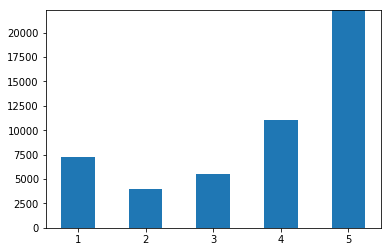

In [7]:
X = np.arange(len(ratingCounts))
pl.bar(X, ratingCounts.values(), align='center', width=0.5)
pl.xticks(X, ratingCounts.keys())
ymax = max(ratingCounts.values()) + 1
pl.ylim(0, ymax)
pl.show()

#### Each review ID is unique in our sample of 50000 reviews, which makes sense because it's normal for every review to have its own individual ID

In [8]:
reviewIds = defaultdict(int)
for d in dataset:
    reviewIds[d['review_id']] += 1
len(reviewIds)

50000

#### There are 42,988 unique user IDs in our sample of 50,000 reviews. If there had been fewer unique IDs, we could have potentially considered individual user rating habits (what the average rating a particular user gives is) in our predictions, but since there are a lot of unique IDs, we don't have enough information to draw conclusion about the user rating habits.

In [9]:
userIds = defaultdict(int)
for d in dataset:
    userIds[d['user_id']] += 1
len(userIds)

42988

#### There are 10,659 unique business IDs in our sample. This is considerably less than the number of unique user IDs, so trying to consider a business's average rating when making a prediction would probably work better, but at the same time I don't think we have enough data to use that to make predictions.

In [10]:
businessIds = defaultdict(int)
for d in dataset:
    businessIds[d['business_id']] += 1
len(businessIds)

10659

In [11]:
bReview_counts = [(businessIds[w], w) for w in businessIds]
bReview_counts.sort()
bReview_counts.reverse()
bReview_counts[:10]

[(376, 'ujHiaprwCQ5ewziu0Vi9rw'),
 (281, 'faPVqws-x-5k2CQKDNtHxw'),
 (279, 'Wxxvi3LZbHNIDwJ-ZimtnA'),
 (270, 'HhVmDybpU7L50Kb5A0jXTg'),
 (264, 'XXW_OFaYQkkGOGniujZFHg'),
 (194, 'pH0BLkL4cbxKzu471VZnuA'),
 (152, 'yNPh5SO-7wr8HPpVCDPbXQ'),
 (150, 'uuGL8diLlHfeUeFuod3F-w'),
 (148, 'Xg5qEQiB-7L6kGJ5F4K3bQ'),
 (147, 'N0apJkxIem2E8irTBRKnHw')]

In [12]:
reviews_by_bId = defaultdict(list)
for d in dataset:
    reviews_by_bId[d['business_id']].append(d)

In [13]:
bIds = businessIds.keys()

In [14]:
businessRatings = dict.fromkeys(bIds, 0)
for d in dataset:
    businessRatings[d['business_id']] += d['stars']

In [15]:
for b in businessRatings:
    businessRatings[b] /= businessIds[b]

In [16]:
businessRatings['ujHiaprwCQ5ewziu0Vi9rw']

3.3351063829787235

#### Moving onto user ratings of reviews, 45.548% of the reviews have useful ratings, 20.046% of the reviews have funny ratings, and 24.454% of the reviews have cool ratings. There are generally more 4- and 5- star reviews rated as either useful, funny, or cool than 1-, 2-, or 3-star reviews, but there are also a considerable number of 1-star reviews rated as useful or funny, so I don't think either of those would be as helpful in discerning between positive and negative reviews. Compared to that, 73.46% of reviews rated as cool are either 4- or 5-star reviews, so determining whether a review was rated as cool could help predict star rating. However, less than a quarter of total reviews were rated as being 'cool', so it might not be that helpful.

In [17]:
useful = 0
funny = 0
cool = 0
usefulR = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
funnyR = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
coolR = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for d in dataset:
    if d['useful'] > 0:
        useful += 1
        usefulR[d['stars']] += 1
    if d['funny'] > 0:
        funny += 1
        funnyR[d['stars']] += 1
    if d['cool'] > 0:
        cool += 1
        coolR[d['stars']] += 1
useful / len(dataset), funny / len(dataset), cool / len(dataset)

(0.45548, 0.20046, 0.24454)

In [18]:
usefulR

{1: 4143, 2: 2047, 3: 2653, 4: 5129, 5: 8802}

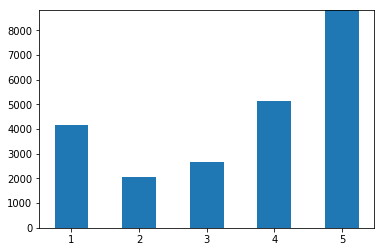

In [19]:
X = np.arange(len(usefulR))
pl.bar(X, usefulR.values(), align='center', width=0.5)
pl.xticks(X, usefulR.keys())
ymax = max(usefulR.values()) + 1
pl.ylim(0, ymax)
pl.show()

In [20]:
funnyR

{1: 1960, 2: 1051, 3: 1335, 4: 2423, 5: 3254}

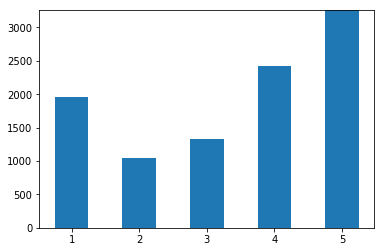

In [21]:
X = np.arange(len(funnyR))
pl.bar(X, funnyR.values(), align='center', width=0.5)
pl.xticks(X, funnyR.keys())
ymax = max(funnyR.values()) + 1
pl.ylim(0, ymax)
pl.show()

In [22]:
coolR

{1: 1046, 2: 747, 3: 1452, 4: 3565, 5: 5417}

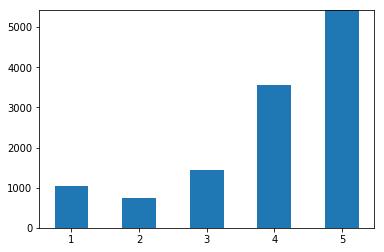

In [23]:
X = np.arange(len(coolR))
pl.bar(X, coolR.values(), align='center', width=0.5)
pl.xticks(X, coolR.keys())
ymax = max(coolR.values()) + 1
pl.ylim(0, ymax)
pl.show()

#### Finally, analyzing the 'text' section of the reviews, since there is a lot of diversity in the kinds of words you can see in the reviews, but also common patterns of words that you see within each type of review, I think a word analysis with the review text could definitely be helpful in the predictive task.

In [24]:
punctuation = set(string.punctuation)
stopwords = set(STOPWORDS)

In [40]:
wordCount = defaultdict(int)
for d in dataset:
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in stopwords:
            continue
        wordCount[w] += 1

In [41]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=wordCount)

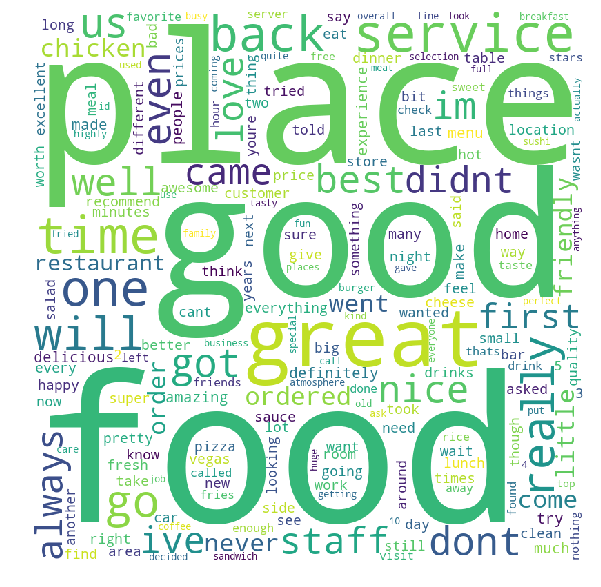

In [42]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [44]:
five = defaultdict(int)
four = defaultdict(int)
three = defaultdict(int)
two = defaultdict(int)
one = defaultdict(int)

for d in dataset:
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in stopwords:
            continue
        if d['stars'] == 5:
            five[w] += 1
        elif d['stars'] == 4:
            four[w] += 1
        elif d['stars'] == 3:
            three[w] += 1
        elif d['stars'] == 2:
            two[w] += 1
        else:
            one[w] += 1

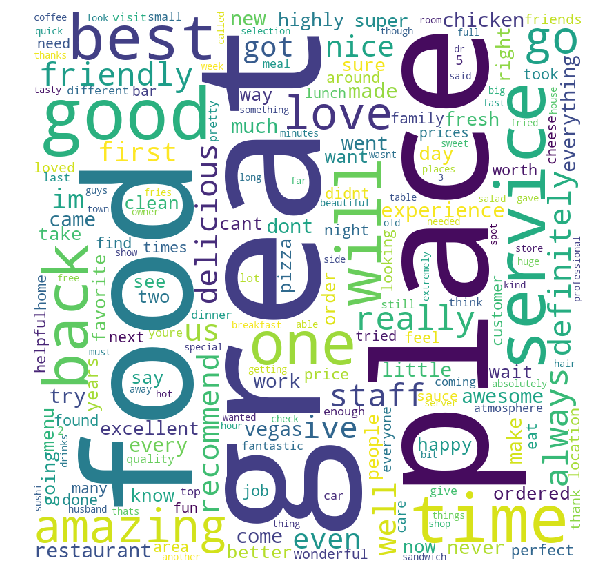

In [46]:
wordcloud5 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=five)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud5)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

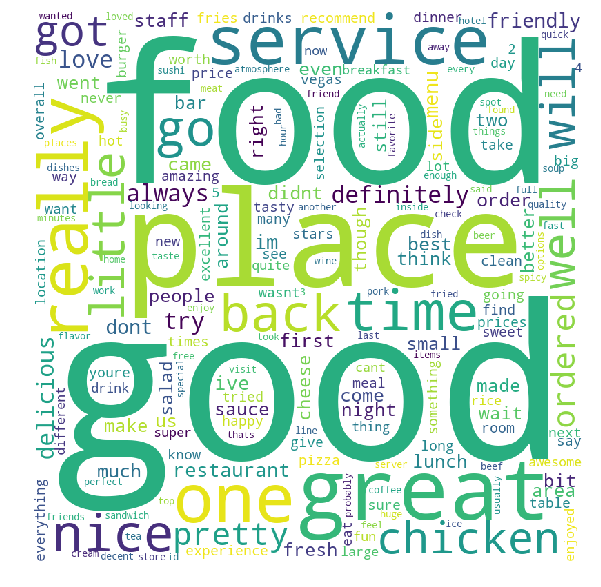

In [48]:
wordcloud4 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=four)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud4)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

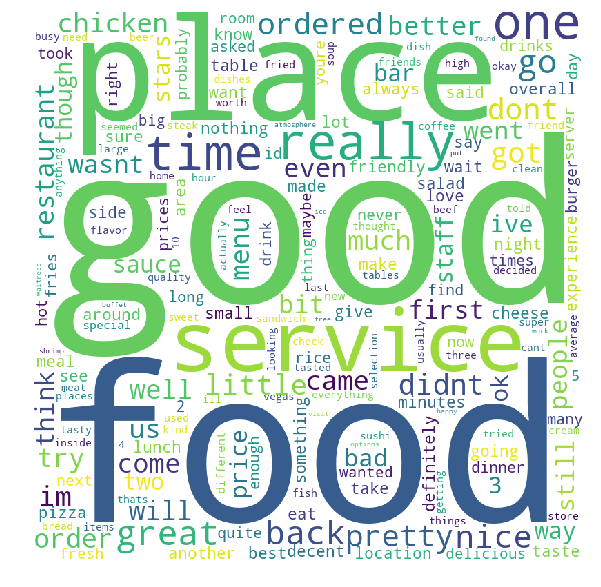

In [49]:
wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=three)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud3)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

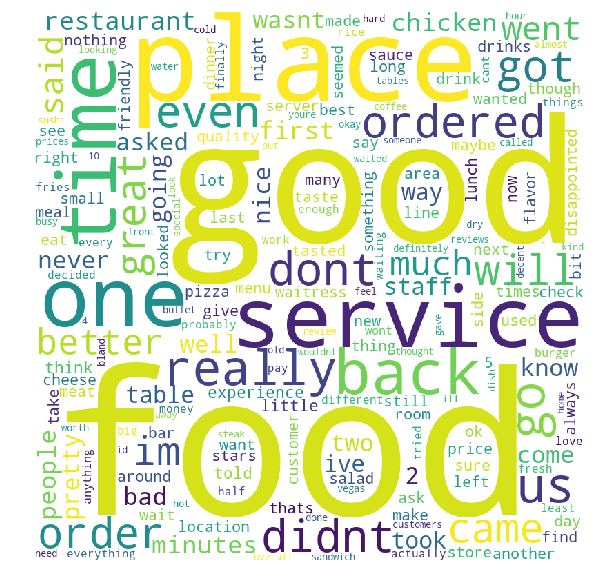

In [50]:
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=two)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

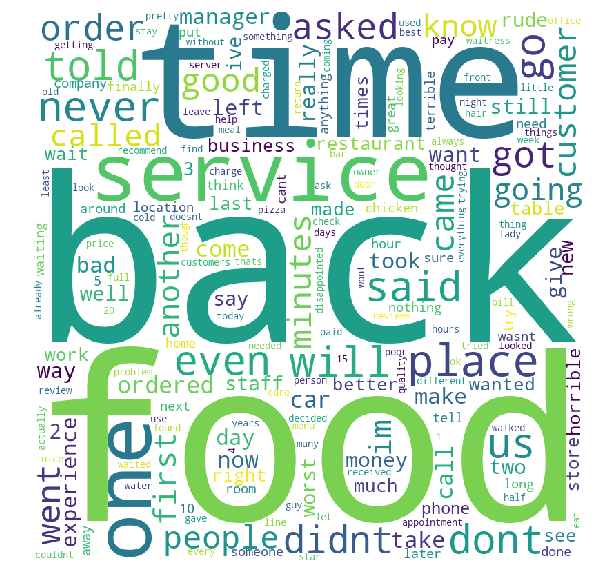

In [51]:
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(frequencies=one)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()